In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import VeraRubin as vr
import numpy as np

from lsst.afw.image import ExposureF, MaskedImageF, ImageF
from lsst.source.injection import VisitInjectConfig, VisitInjectTask, generate_injection_catalog
from lsst.geom import SpherePoint, degrees

from astropy.io import fits

In [3]:
def apply_correction_to_stamp(
        stamp_file,
        rotation_angle,
        output_path=None,
        keep_size=False,
        interp_order=3,
        update_wcs=True,
        c=1,
        from_data=False,
        warping_kernel='lanczos4',
        radius_pixels=120,  # new
        center_coord=None  # new
    ):
    """
    Rotate/Shift a FITS (Flexible Image Transport System) stamp image by a given angle (anticlockwise), optionally updating the WCS.

    Parameters:
    -----------
    stamp_file : str
        Path to the input FITS stamp.
    rotation_angle : float
        Rotation angle in degrees (anticlockwise).
    output_path : str
        Path to save the rotated FITS file.
    keep_size : bool
        If True, keeps the original image size (cropping or padding as needed).
    interp_order : int
        Interpolation order for rotation (0=nearest, 1=linear, 3=cubic).
    update_wcs : bool
        If True, rotate and update the WCS information in the header.
    from_data : bool
        if True used the function apply_correction_from_data else apply_correction_from_exposureF
    warping_kernel : str
        Interpolation kernel for warping. Options: "lanczos3", "bilinear", etc.

    Returns:
    --------
    str or astropy.io.fits.HDUList
        Path to the rotated FITS file if output_path is given, else HDU object.

    see:
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.rotate.html
    """
    try:
        # Load the original data and header
        with fits.open(stamp_file) as hdul:
            data = hdul[0].data.astype(np.float32, copy=False)  # Give the pixels of the first extension
            hdr = hdul[0].header.copy()  # Copy its metadata (header)
            # Note: The header may contain WCS (World Coordinate System) keywords such as:
            # NAXIS1, NAXIS2: size of the image in pixels along X and Y axes.
            # CRPIX1, CRPIX2: pixel coordinates of the reference point in the image.
            #                 This is the “anchor” pixel used for coordinate transformations.
            # CRVAL1, CRVAL2: celestial coordinates (RA/Dec in degrees) corresponding to the reference pixel (CRPIX1, CRPIX2).
            #                  They define the position on the sky that the reference pixel represents.
            # CDELT1, CDELT2: pixel scale in degrees per pixel along X and Y axes.
            #                  They are used to convert pixel offsets to sky coordinate offsets.
            # CTYPE1, CTYPE2: type of projection used for mapping the sky onto the image (e.g., 'TAN' for gnomonic, 'CAR' for Cartesian).
            #                  Determines how RA/Dec are computed for pixels away from the reference pixel.
            # etc.
            # Using these WCS parameters, the celestial coordinates (RA, Dec) of any pixel (x, y) can be calculated as:
            #   RA  = CRVAL1 + (x - CRPIX1) * CDELT1 (with projection applied by CTYPE1)
            #   Dec = CRVAL2 + (y - CRPIX2) * CDELT2 (with projection applied by CTYPE2)
            # This allows transforming pixel positions to accurate sky coordinates.

        exposure_ref = fits_to_exposure(data, hdr)
        
        if from_data:
            rotated_data, hdr_new = vr.apply_correction_from_data(
                data, hdr, rotation_angle,
                keep_size=keep_size, interp_order=interp_order, update_wcs=update_wcs, c=c
            )
        else:
            rotated_data, hdr_new = vr.apply_correction_from_exposureF(
                data, hdr, rotation_angle,
                warping_kernel=warping_kernel,
                keep_size=keep_size,
                update_wcs=update_wcs
            )

        rotated_exposure = fits_to_exposure(rotated_data, hdr_new)
        ### New -> same size Making a referential point
        radius_pixels = radius_pixels
        # center_coord = center_coord if center_coord else (np.array(data.shape)/2).astype(int)
        inX, inY = exposure_ref.image.array.shape[0]/2, exposure_ref.image.array.shape[0]/2
        center_coord = exposure_ref.getWcs().pixelToSky(inX, inY)
        
        # rotated_data, hdr_new = cutout_fits(rotated_data, hdr_new, center_coord, radius_pixels, info=False, ext=0)
        rotated_cut_exposure = cutout_exposure(rotated_exposure, center_coord, radius_pixels, info=False)

        exposures = [exposure_ref, rotated_exposure, rotated_cut_exposure]
        #plot_exposures_with_point(exposures, exposures[0].getWcs().pixelToSky(center_coord[0], center_coord[1]),
        #                  ['Original', 'Rotada', 'Rot y Recortada'],
        #                 ['pixel', 'pixel'])
        plot_exposures_with_point(exposures, center_coord,
                          ['Original', 'Rotada', 'Rot y Recortada'],
                         ['pixel', 'pixel'])
        
        ##################

        rotated_data, hdr_new = exposure_to_fits_datahdr(rotated_cut_exposure)
        
        # Create new HDU with rotated data and header
        hdu = fits.PrimaryHDU(data=rotated_data, header=fits.Header(hdr_new)) # Dumps the modified WCS back to the header. Thus the FITS you are going to write will already have the rotated WCS.
        # IMPORTANT: This methodology ajust only the linear part (orientation/scale). If the "header" has distortions (SIP A_*, B_*, PV/TPV…), 
        #            they are not recalculated here. For distorted mappings, reprojection with tools like reproject would be needed.

        # Remove NAXIS1/NAXIS2 to let FITS recalc from data shape
        for key in ['NAXIS1', 'NAXIS2']:
            hdu.header.pop(key, None)

        # Add metadata about rotation
        hdu.header['ROT_ANG'] = (rotation_angle, 'Rotation applied (deg, anticlockwise)')
        #hdu.header['ROT_KEEP'] = (keep_size, 'True if original image size kept')
        hdu.header['ROT_INT'] = (interp_order, 'Interpolation order used')
        
        # Save to file if requested
        if output_path:
            hdu.writeto(output_path, overwrite=True)
            return output_path
        else:
            return hdu

    except Exception as e:
        print(f"Error rotating stamp '{stamp_file}': {e}")
        return None

def exposure_to_fits_datahdr(exposure):
    """
    Convert an LSST Exposure to FITS-like (data, header).

    Parameters
    ----------
    exposure : `lsst.afw.image.Exposure`
        Input exposure.

    Returns
    -------
    data : 2D numpy.ndarray
        Image array from the exposure.
    hdr : astropy.io.fits.Header
        FITS header including WCS metadata.
    """
    import numpy as np
    from astropy.io import fits

    # Extract image array
    mi = exposure.getMaskedImage()
    data = mi.getImage().getArray()

    # Build WCS header
    wcs = exposure.getWcs()
    hdr = fits.Header()
    hdr.update(wcs.getFitsMetadata())

    return data, hdr
        
def fits_to_exposure(data, hdr, variance_init=1.0):
    """
    Convert a NumPy array + FITS header into an LSST ExposureF,
    initializing variance and mask planes.
    
    Parameters
    ----------
    data : np.ndarray
        Image data (2D array).
    hdr : astropy.io.fits.Header
        FITS header with WCS keywords.
    variance_init : float, optional
        Default variance value to assign to all pixels.
    
    Returns
    -------
    exposure : lsst.afw.image.ExposureF
        LSST Exposure with WCS, mask, and variance.
    """
    import lsst.geom as geom
    from lsst.afw.geom import makeSkyWcs
    from lsst.afw.image import ImageF, Mask, MaskedImageF, ExposureF
    
    # Create image plane
    image = ImageF(data.astype(np.float32, order="C"), deep=False)

    # Initialize mask (all zeros = good pixels)
    mask = Mask(image.getDimensions())
    mask.set(0)

    # Initialize variance plane (constant value, 1.0)
    variance = ImageF(image.getDimensions())
    variance.set(variance_init)

    # Build masked image (image, mask, variance)
    masked = MaskedImageF(image, mask, variance)

    # Wrap into an ExposureF
    exposure = ExposureF(masked)

    # Build LSST SkyWcs from FITS header keywords
    crpix = geom.Point2D(hdr["CRPIX1"], hdr["CRPIX2"])
    crval = geom.SpherePoint(hdr["CRVAL1"] * geom.degrees,
                             hdr["CRVAL2"] * geom.degrees)
    cd_matrix = np.array([[hdr["CD1_1"], hdr["CD1_2"]],
                          [hdr["CD2_1"], hdr["CD2_2"]]])

    skyWcs = makeSkyWcs(crpix, crval, cd_matrix)
    exposure.setWcs(skyWcs)

    return exposure

def cutout_exposure(ref_exposure, center_coord, radius_pixels, info=True):
    """
    Cut out an LSST exposure centered on a celestial position with a given radius.
    If the cutout exceeds the image boundaries, missing regions are filled with zeros.
    Updates the WCS of the cutout to remain consistent.

    Parameters
    ----------
    ref_exposure : `lsst.afw.image.Exposure`
        Input exposure.
    center_coord : `lsst.afw.coord.Coord`
        Cutout center in celestial coordinates.
    radius_pixels : float
        Radius of the cutout in pixels.

    Returns
    -------
    cutout_exp : `lsst.afw.image.Exposure`
        Cutout exposure with updated WCS.
    """
    import lsst.geom as geom
    import lsst.afw.image as afwImage
    import numpy as np

    wcs = ref_exposure.getWcs()
    bbox = ref_exposure.getBBox()

    # Convert celestial center to pixel coordinates
    center_point = wcs.skyToPixel(center_coord)

    # Desired cutout BBox
    size = int(2 * radius_pixels)
    min_x = int(center_point.getX() - radius_pixels)
    min_y = int(center_point.getY() - radius_pixels)
    desired_bbox = geom.Box2I(geom.Point2I(min_x, min_y), geom.Extent2I(size, size))

    # Checking if box is subset of desired_bbox
    # when this happened intersect_bbox is clipped to box
    intersect_bbox = desired_bbox.clippedTo(bbox)
    is_subset = (intersect_bbox != bbox)

    if is_subset:
        # Case when intersect_bbox is subset of bbox
        x0, y0 = 0, 0
    else:
        # Case when bbox is subset of intersect_bbox
        x0 = intersect_bbox.getMinX() - desired_bbox.getMinX()
        y0 = intersect_bbox.getMinY() - desired_bbox.getMinY()

    # Create empty arrays for image, mask, and variance
    dtype = ref_exposure.getMaskedImage().getImage().getArray().dtype
    empty_image = np.zeros((size, size), dtype=dtype)
    empty_mask = np.zeros((size, size), dtype=np.uint16)
    empty_variance = np.zeros((size, size), dtype=dtype)

    # Copy image, mask, and variance from the original
    mi = ref_exposure.getMaskedImage()
    empty_image[y0:y0 + intersect_bbox.getHeight() - 1, x0:x0 + intersect_bbox.getWidth() - 1] = \
            mi.getImage().getArray()[intersect_bbox.getMinY():intersect_bbox.getMaxY(),
                                 intersect_bbox.getMinX():intersect_bbox.getMaxX()]
    empty_mask[y0:y0 + intersect_bbox.getHeight() - 1, x0:x0 + intersect_bbox.getWidth() - 1] = \
            mi.getMask().getArray()[intersect_bbox.getMinY():intersect_bbox.getMaxY(),
                                intersect_bbox.getMinX():intersect_bbox.getMaxX()]
    empty_variance[y0:y0 + intersect_bbox.getHeight() - 1, x0:x0 + intersect_bbox.getWidth() - 1] = \
            mi.getVariance().getArray()[intersect_bbox.getMinY():intersect_bbox.getMaxY(),
                                    intersect_bbox.getMinX():intersect_bbox.getMaxX()]
        
    # Create MaskedImage and Exposure
    mi_cutout = afwImage.MaskedImageF(empty_image.shape[1], empty_image.shape[0])
    mi_cutout.getImage().getArray()[:, :] = empty_image
    mi_cutout.getMask().getArray()[:, :] = empty_mask
    mi_cutout.getVariance().getArray()[:, :] = empty_variance

    cutout_exp = afwImage.ExposureF(mi_cutout)

    # Shift WCS
    shift = geom.Extent2D(-desired_bbox.getMinX(), -desired_bbox.getMinY())
    shifted_wcs = wcs.copyAtShiftedPixelOrigin(shift)
    cutout_exp.setWcs(shifted_wcs)
    
    if info:
        center_point_cutout = cutout_exp.getWcs().skyToPixel(center_coord)
        print("Referential point in exposure:", center_point)
        print("Desired bbox:", desired_bbox)
        print("Intersection bbox:", intersect_bbox)
        print("Referential point in cutout:", center_point_cutout)
        print("Cutout shape:", cutout_exp.getMaskedImage().getImage().getArray().shape)

    return cutout_exp

def plot_exposures_with_point(exposures, center_coord=None,
                              titles=None, axeslabels=None,
                              save_path=None, percentiles=[0.1, 99.9]):
    """
    Plot one or multiple LSST exposures side by side, optionally marking a sky coordinate.

    Parameters
    ----------
    exposures : list of `lsst.afw.image.Exposure`
        List of exposures to plot.
    center_coord : `lsst.afw.coord.Coord`, optional
        Celestial coordinate to mark in each exposure (red star).
    titles : list of str, optional
        Titles for each subplot.
    axeslabels : list of str, optional
        Axis labels as [xlabel, ylabel].
    save_path : str, optional
        If provided, saves the figure to this path.
    """
    ncol = len(exposures)

    fig, axes = plt.subplots(1, ncol, figsize=(ncol*5, 4))

    if ncol == 1:
        axes = [axes]

    for ind, (ax, exp) in enumerate(zip(axes, exposures)):
        # imag = exp.getImage().getArray()
        try:
            imag = exp.getImage().getArray()
        except Exception as e:
            print(f"Warning: The data is not an exposure ({e})")
            imag = exp
        
        ax.imshow(imag, origin='lower', cmap='gray',
                  vmin=np.nanpercentile(imag, percentiles[0]),
                  vmax=np.nanpercentile(imag, percentiles[1]))

        if titles and ind < len(titles):
            ax.set_title(titles[ind])

        if axeslabels and len(axeslabels) == 2:
            ax.set_xlabel(axeslabels[0])
            ax.set_ylabel(axeslabels[1])

        if center_coord:
            center_point = exp.getWcs().skyToPixel(center_coord)

            # Check if the point lies within the image boundaries
            if (0 <= center_point.getX() < imag.shape[1] and
                0 <= center_point.getY() < imag.shape[0]):
                ax.plot(center_point.getX(), center_point.getY(),
                        'r*', markersize=8)

    plt.tight_layout()

    # Save or show
    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches="tight")
        print(f"[INFO] Figure saved to {save_path}")
    else:
        plt.show()
        
    plt.close(fig)  # free memory
    return None


def normalize_exposures(exp_ref, exp_coadd, method="rescale"):
    """
    Normalize two LSST Exposure images to the same intensity range,
    returning full ExposureF objects with metadata preserved.

    Parameters
    ----------
    exp_ref : lsst.afw.image.ExposureF
        Reference exposure
    exp_coadd : lsst.afw.image.ExposureF
        Coadd exposure
    method : str, optional
        Normalization method:
        - "rescale": Rescale intensity of each image independently to [0,1]
        - "global_rescale": Rescale both using the global min and max
        - "zscore": Normalize to zero mean and unit variance

    Returns
    -------
    exp_ref_norm : lsst.afw.image.ExposureF
        Normalized reference exposure
    exp_coadd_norm : lsst.afw.image.ExposureF
        Normalized coadd exposure
    """

    # Convert Exposure -> NumPy arrays
    img_ref = exp_ref.getImage().getArray()
    img_coadd = exp_coadd.getImage().getArray()

    if method == "rescale":
        ref_norm = (img_ref - np.min(img_ref)) / (np.max(img_ref) - np.min(img_ref))
        coadd_norm = (img_coadd - np.min(img_coadd)) / (np.max(img_coadd) - np.min(img_coadd))

    elif method == "global_rescale":
        global_min = min(np.min(img_ref), np.min(img_coadd))
        global_max = max(np.max(img_ref), np.max(img_coadd))
        ref_norm = (img_ref - global_min) / (global_max - global_min)
        coadd_norm = (img_coadd - global_min) / (global_max - global_min)

    elif method == "zscore":
        ref_norm = (img_ref - np.mean(img_ref)) / np.std(img_ref)
        coadd_norm = (img_coadd - np.mean(img_coadd)) / np.std(img_coadd)

    else:
        raise ValueError("Invalid method. Choose 'rescale', 'global_rescale', or 'zscore'.")

    # --- Build normalized ExposureF with metadata preserved ---
    def build_normalized_exposure(exp_original, norm_array):
        # Make a deep copy of the original exposure
        exp_copy = exp_original.clone()

        # Replace only the image plane with normalized values
        exp_copy.getImage().getArray()[:, :] = norm_array.astype(np.float32)

        return exp_copy

    exp_ref_norm = build_normalized_exposure(exp_ref, ref_norm)
    exp_coadd_norm = build_normalized_exposure(exp_coadd, coadd_norm)

    return exp_ref_norm, exp_coadd_norm


In [4]:
# Butler
butler = vr.ExpButler(info=False).butler  # using default adress

In [5]:
# Defining the sky coordinates and the selected band
ra_deg, dec_deg = (53.2, -27.8)  # RA, Dec
loc_data = (ra_deg, dec_deg)
band = 'u'

# Opening the FITS file
stamp_paths = ['stamp/test.fits']

# Defining the properties of the stamp
mags = [14.8]  # Magnitude used to inject the stamp

# Sky position of the injection
ra_list, dec_list = [ra_deg], [dec_deg]

In [6]:
# Opening the stamp
with fits.open(stamp_paths[0]) as hdul:
    data_stamp = hdul[0].data  # Give the pixels of the first extension
    hdr_stamp = hdul[0].header.copy()
    if "MASK" in [hdu.name for hdu in hdul]:
        mask = hdul["MASK"].data.astype(bool)
    else:
        mask = np.isfinite(data_stamp)  # check if the mask is identify by NaN value

In [7]:
# Converting to exposure
exposure_ref = fits_to_exposure(data_stamp, hdr_stamp)

## Making a visit coadd

In [8]:
# considering the visits
visits = {
        "0": {
                "instrument": "LSSTComCam",
                "detector": 0,
                "visit": 2024113000172,
                "band": "u",
                "day_obs": 20241130,
                "physical_filter": "u_02"
            },
        "1": {
                "instrument": "LSSTComCam",
                "detector": 3,
                "visit": 2024113000176,
                "band": "u",
                "day_obs": 20241130,
                "physical_filter": "u_02"
            },
        "2": {
                "instrument": "LSSTComCam",
                "detector": 3,
                "visit": 2024113000175,
                "band": "u",
                "day_obs": 20241130,
                "physical_filter": "u_02"
            },
        "3": {
                "instrument": "LSSTComCam",
                "detector": 0,
                "visit": 2024120100190,
                "band": "u",
                "day_obs": 20241201,
                "physical_filter": "u_02"
            },
        "4": {
                "instrument": "LSSTComCam",
                "detector": 3,
                "visit": 2024120100181,
                "band": "u",
                "day_obs": 20241201,
                "physical_filter": "u_02"
            }
}

In [9]:
# Load exposures, compute SNR + WCS

snr_list, getWcs_list = [], []
for Id in visits.keys():
    try:
        exp = butler.get("visit_image", dataId=visits[Id])
        snr_list.append(vr.measure_quality(exp))
        getWcs_list.append(exp.getWcs())
        del exp  # free memory early
    except Exception as e:
        print(f"[ERROR] Could not load exposure {ref.dataId}: {e}")
    
# Sort by SNR
sorter_snr = np.argsort(snr_list)[::-1]  # descending
sort_visit_calexp_dataset = [visits[str(i)] for i in sorter_snr]
sort_getWcs_list = [getWcs_list[i] for i in sorter_snr]

In [10]:
# Compute relative rotation angles w.r.t first visit

ref_wcs = sort_getWcs_list[0]  # referential visit

rotation_angle_list = [0.0]  # reference visit has 0 rotation
rotation_angle_list.extend([
    wcs.getRelativeRotationToWcs(ref_wcs).asDegrees()
    for wcs in sort_getWcs_list[1:]
])

rotation_angle_list

[0.0,
 0.37983940543739286,
 0.36919504542176534,
 353.3704979568793,
 12.171780591654432]

In [11]:
rot_name_save = "test_notebook/stamp_rotated"

# Defining the properties of the stamp
mags = [14.8]  # Magnitude used to inject the stamp

# Sky position of the injection
# ra_deg, dec_deg = (53.2, -27.8)  # RA, Dec

ra_list, dec_list = [ra_deg], [dec_deg]

Angle  0.0


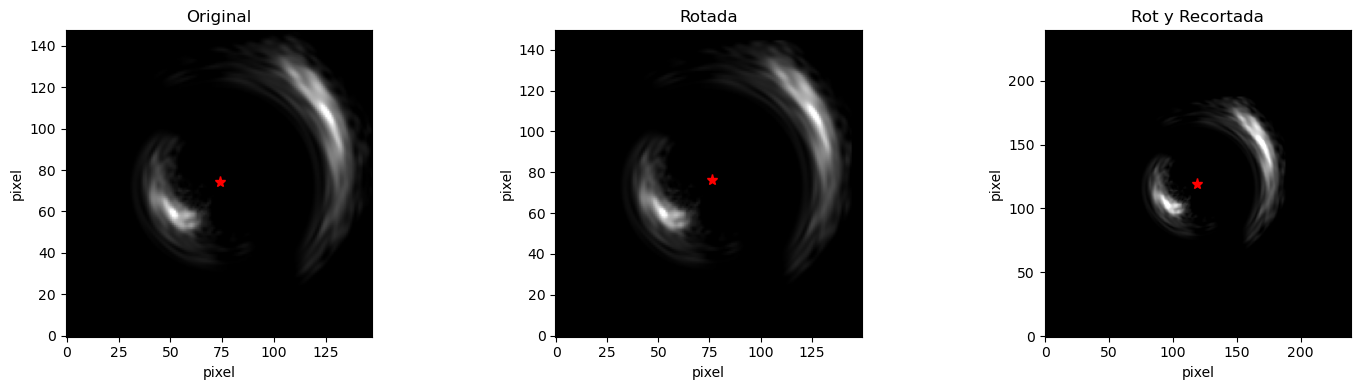

Angle  0.37983940543739286


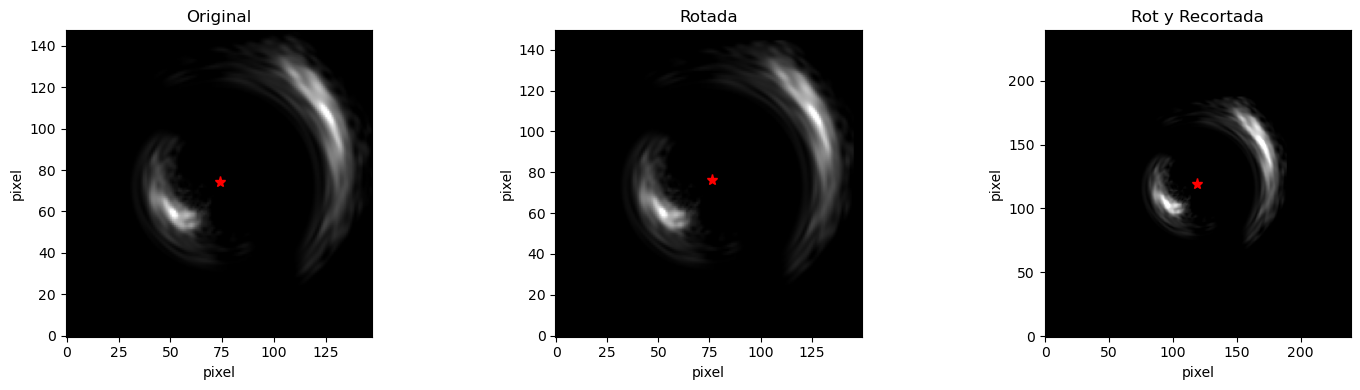

Angle  0.36919504542176534


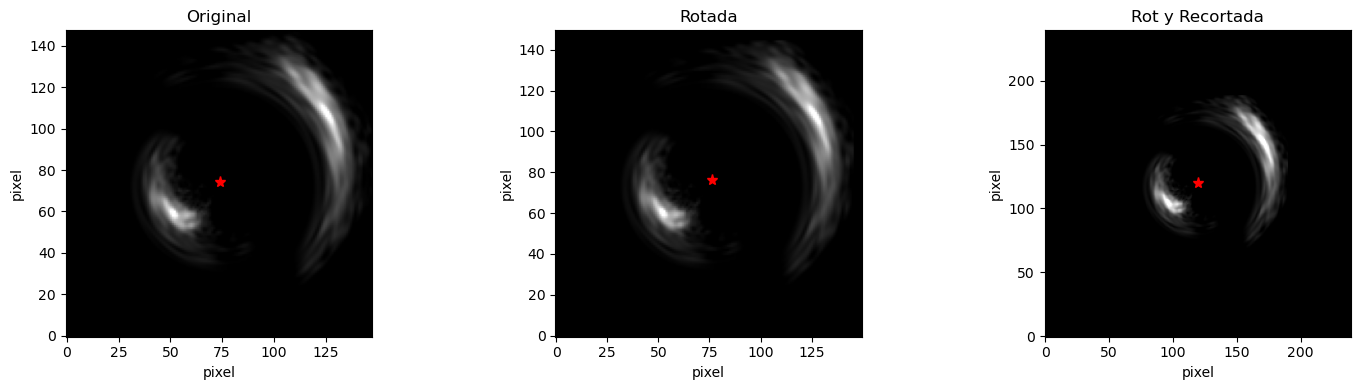

Angle  353.3704979568793


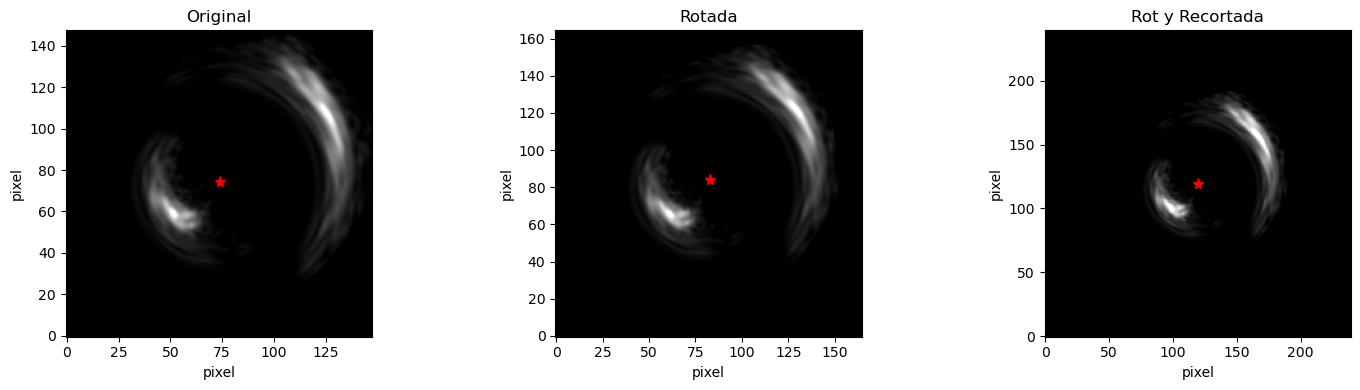

Angle  12.171780591654432


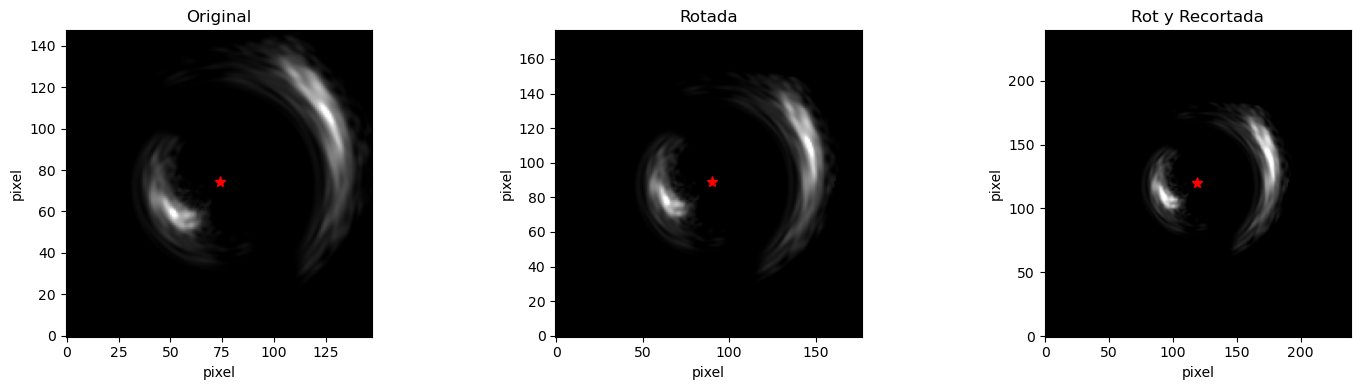

[INFO] Injection complete.


In [12]:
# Rotate stamps, build catalogs, and inject in one loop

injected_exposures = []
for i, angle in enumerate(rotation_angle_list):
    visit_id = sort_visit_calexp_dataset[i]
    visit_image = butler.get("visit_image", dataId=visit_id)

    # Rotate all stamps for this visit
    print("Angle ", angle)
    rotated_stamps_path = [
        apply_correction_to_stamp(
            stamp_file,
            angle,
            output_path=f"{rot_name_save}_angle_{angle}_stamp_{j}.fits",
            keep_size=False,
            interp_order=3,
            update_wcs=True,  # importante
            c=1,
            from_data=False,  # revisar reajuste de tamaño cuando se usa from data
            warping_kernel='lanczos4',
            radius_pixels=120,  # new
            center_coord=None
        )
        for j, stamp_file in enumerate(stamp_paths)
    ]  # [rotate_stamp1_path, rotate_stamp2_path, ...]

    # Create injection catalog
    inj_cat = vr.create_crowded_injection_catalog(
        ra_list,
        dec_list,
        rotated_stamps_path,
        mags,
        min_sep=0.0005,
        separation_spherical=True
    )

    # Perform injection
    try:
        inj_exp = vr.inject_stamp(visit_image, inj_cat)
        injected_exposures.append(inj_exp)
    except Exception as e:
        print(f"[ERROR] Injection failed for visit {visit_image.getInfo().getVisitInfo().getId()}: {e}")

print("[INFO] Injection complete.")

Rotation of:  0.0
[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:171: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


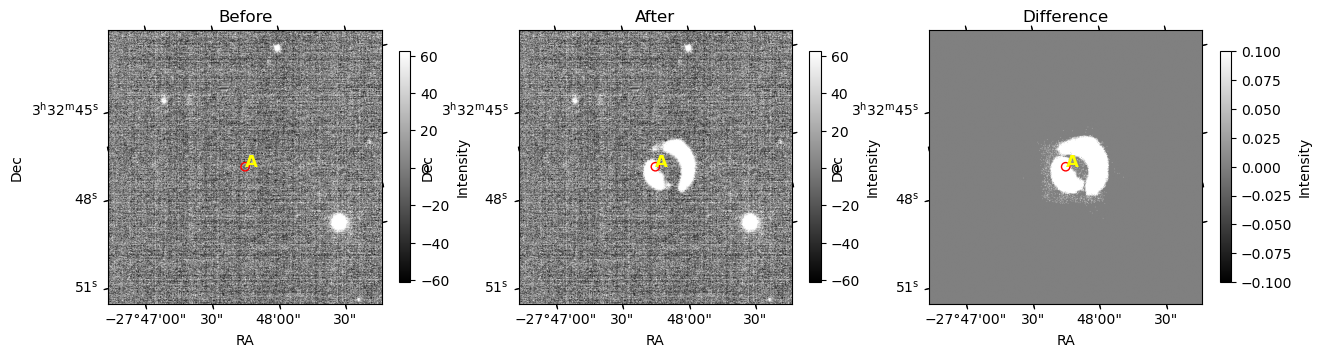

Rotation of:  0.37983940543739286
[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:171: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


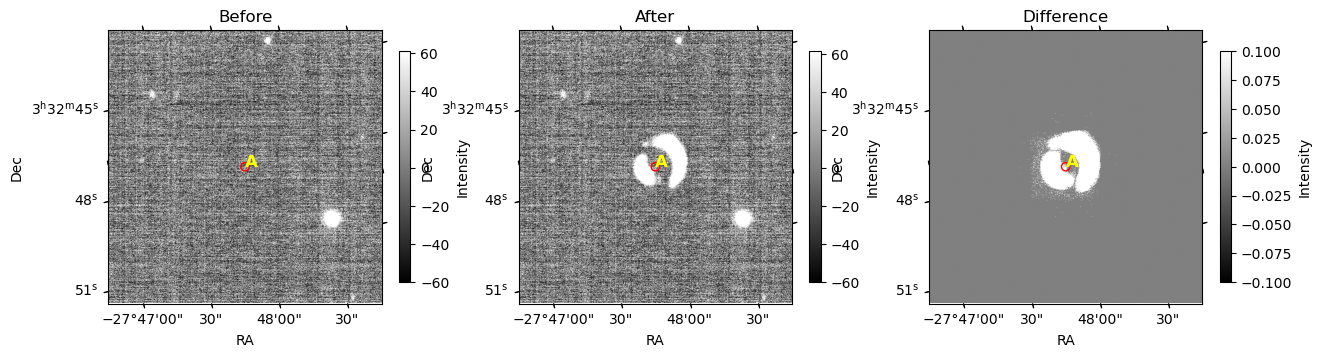

Rotation of:  0.36919504542176534
[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:171: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


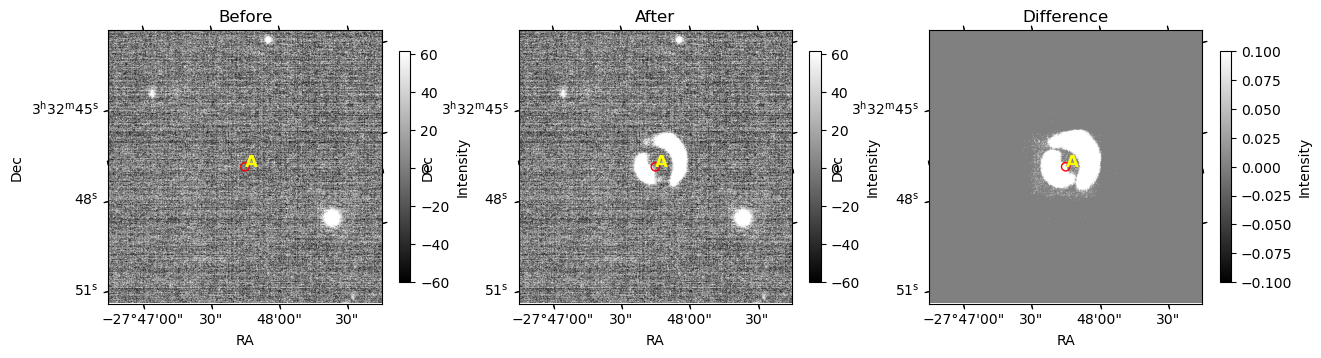

Rotation of:  353.3704979568793
[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:171: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


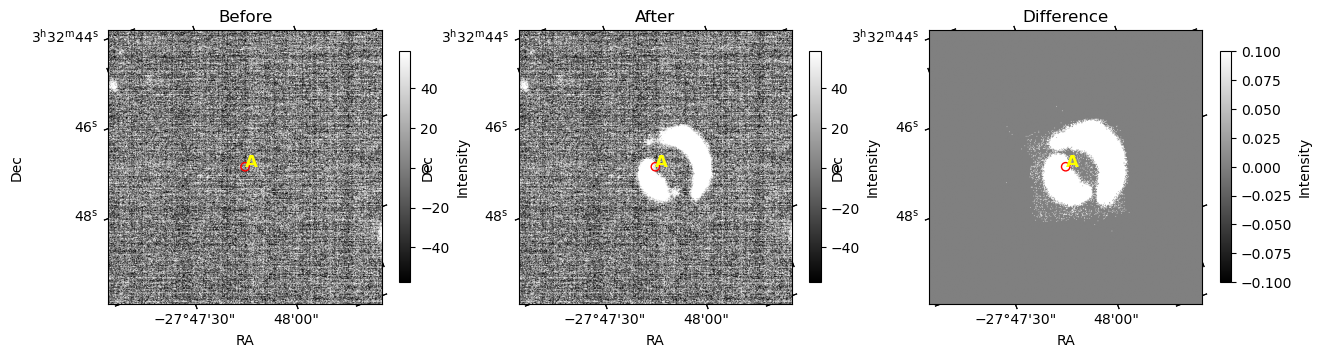

Rotation of:  12.171780591654432
[INFO] Converted LSST SkyWcs -> Astropy WCS


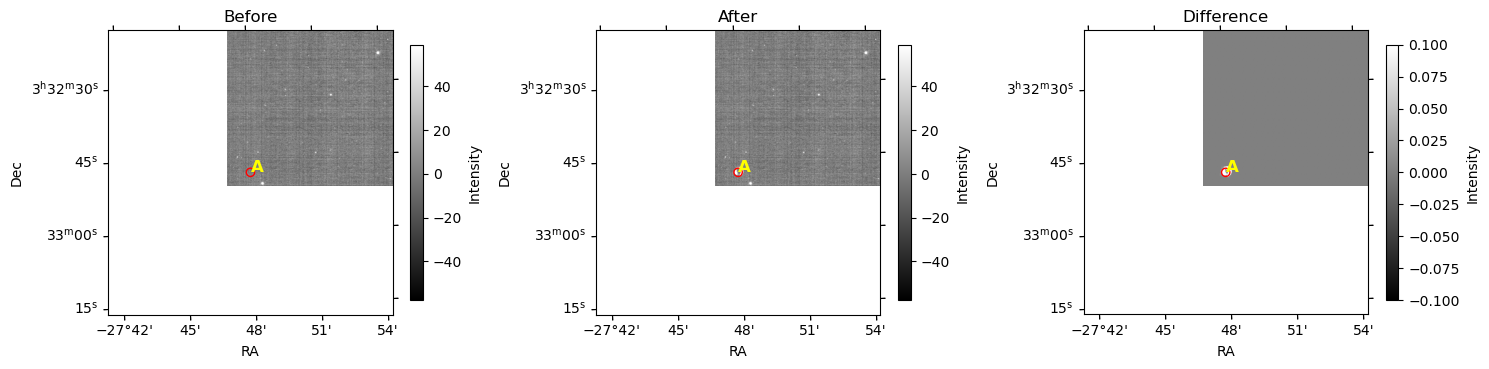

In [13]:
# visualizating full image set

points = [[ra_deg, dec_deg]]
temp = []
for i, angle in enumerate(rotation_angle_list):
    print("Rotation of: ", angle)
    visit_id = sort_visit_calexp_dataset[i]
    before = butler.get("visit_image", dataId=visit_id)
    temp.append(before)
    after = injected_exposures[i]
    vr.injection_steps(before, after, points,
                       diference=True,
                       cutout_radius_arcsec=15,  # arcsec  10
                       grid=False, percentiles=[5, 95])

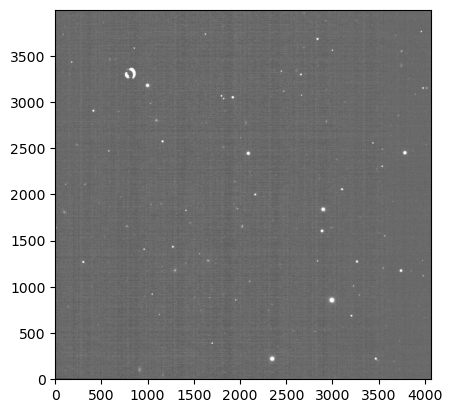

In [14]:
# Visualizating the referential image
img = injected_exposures[0].getImage().getArray()

p5, p95 = np.nanpercentile(img, [0.01, 99.9])
plt.imshow(img, origin='lower', cmap='gray', vmin=p5, vmax=p95)

### Making a coadd 

[INFO] Starting coaddition of 5 exposures...
Warp 1: 0.000% NaN pixels
Offset (degree): 0.0
Rotation angle (degree): 4.185715421596676e-16
→ Total diff: 0.0 Max: 0.0 Min: 0.0


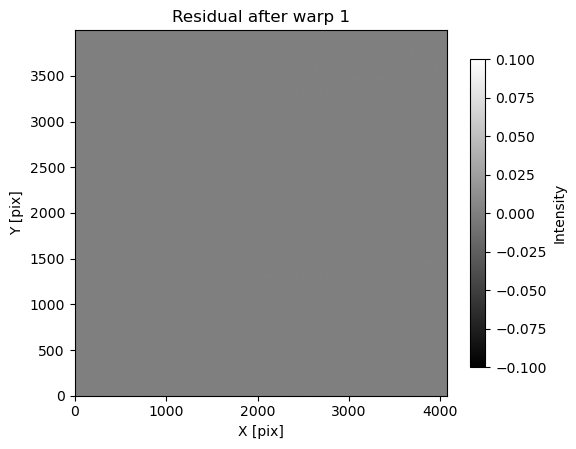

[1/5] exposure coadded.
Warp 2: 67.605% NaN pixels
Offset (degree): 0.13905519505600952
Rotation angle (degree): 0.37983940543739286
→ Total diff: -37351524.0 Max: 153173.77 Min: 0.0


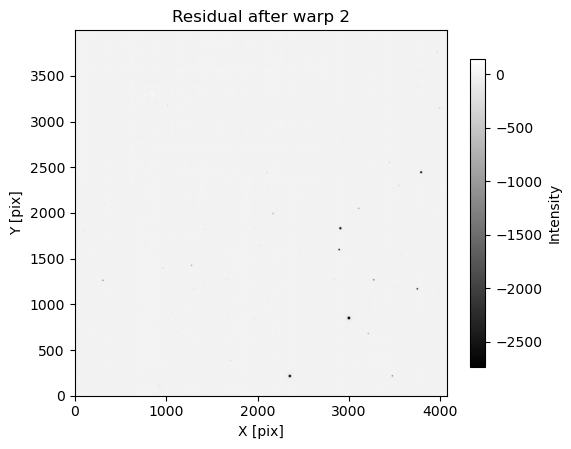

[2/5] exposure coadded.
Warp 3: 19.761% NaN pixels
Offset (degree): 0.03925728190509938
Rotation angle (degree): 0.36919504542176534
→ Total diff: -5743828.5 Max: 34393.26 Min: 0.0


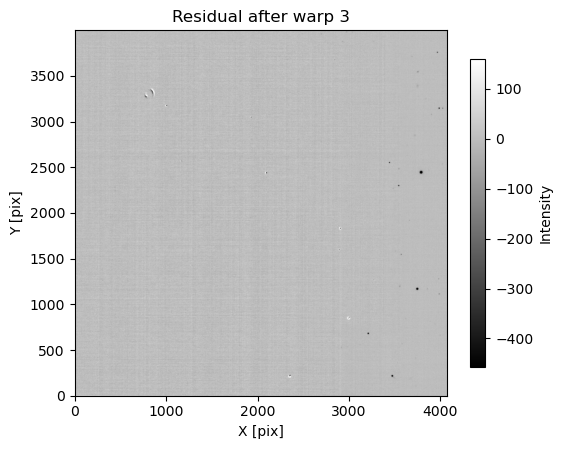

[3/5] exposure coadded.
Warp 4: 55.236% NaN pixels
Offset (degree): 0.10882259244543235
Rotation angle (degree): 353.3704979568793
→ Total diff: -31736134.0 Max: 153173.77 Min: 0.0


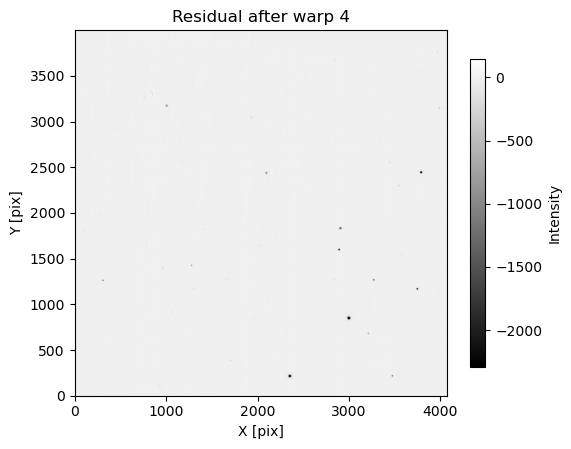

[4/5] exposure coadded.
Warp 5: 86.560% NaN pixels
Offset (degree): 0.18980031978158282
Rotation angle (degree): 12.171780591654432
→ Total diff: -41031828.0 Max: 153173.77 Min: 0.0


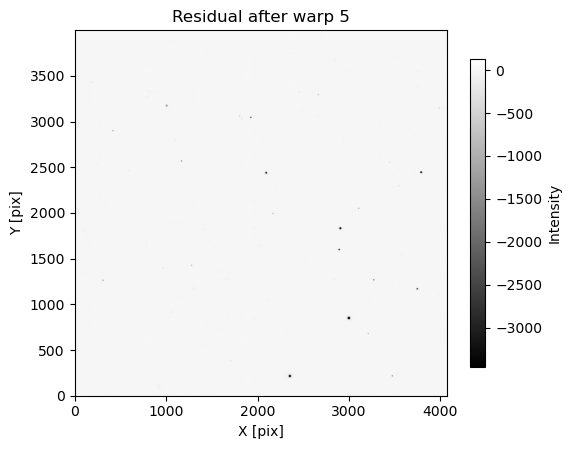

[5/5] exposure coadded.
[INFO] LSST-style coadd saved to ./coadds_test_notebook/band_u_coadd_test3.fits
[INFO] Coverage map saved to ./coadds_test_notebook/coverage_map.fits
Coaddition complete.
Pixels with no coverage: 0 / 16288000


In [15]:

coadded_exp, coverage_map = vr.coadd_exposures_pipeline(
    injected_exposures,  # temp[:2], 
    ref_exp=None,
    warping_kernel="lanczos4",  # "lanczos3"
    save_path="./coadds_test_notebook",
    coadd_name=f"band_{band}_coadd_test3.fits",
    info=True,
    plot_debug=True,
    same_check=True
    )

In [16]:
# Loading the Exposure Coadd
from lsst.afw.image import ExposureF

coadd_exp = ExposureF.readFits(f"./coadds_test_notebook/band_{band}_coadd_test3.fits")

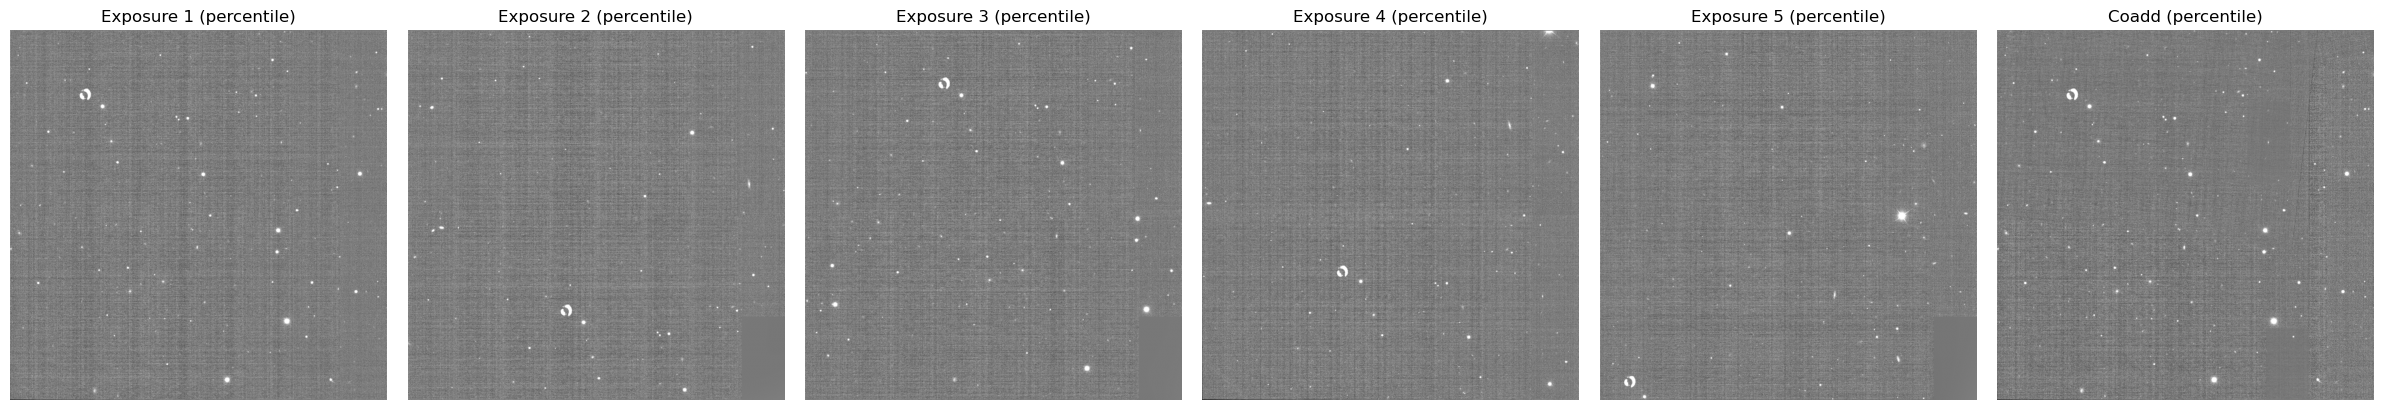

In [17]:
# Visualizing the result 
vr.plot_exposures_and_coadd(injected_exposures,
                         coadded_exp,
                         exposures_scale='percentile', # 'zscale_asinh',
                         coadd_exp_scale='percentile', # 'percentile' zscale_asinh
                         show_second_row=False,
                         save_path=None)

[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:171: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


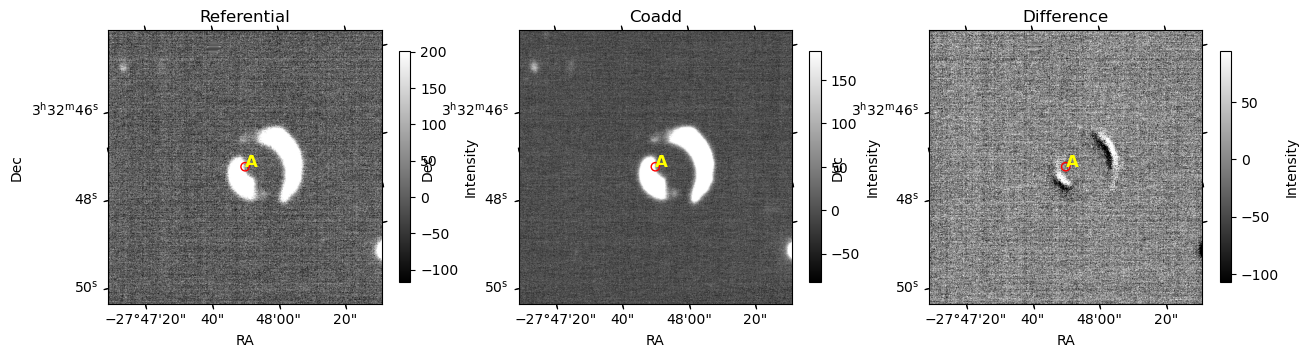

In [18]:
vr.injection_steps(
    injected_exposures[0],
    coadd_exp,
    points,
    diference=True,
    cutout_radius_arcsec=10,  # arcsec points
    grid=False, percentiles=[0.1, 99.9], #[5, 95]
    names=['Referential', 'Coadd', 'Difference'])

[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:171: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


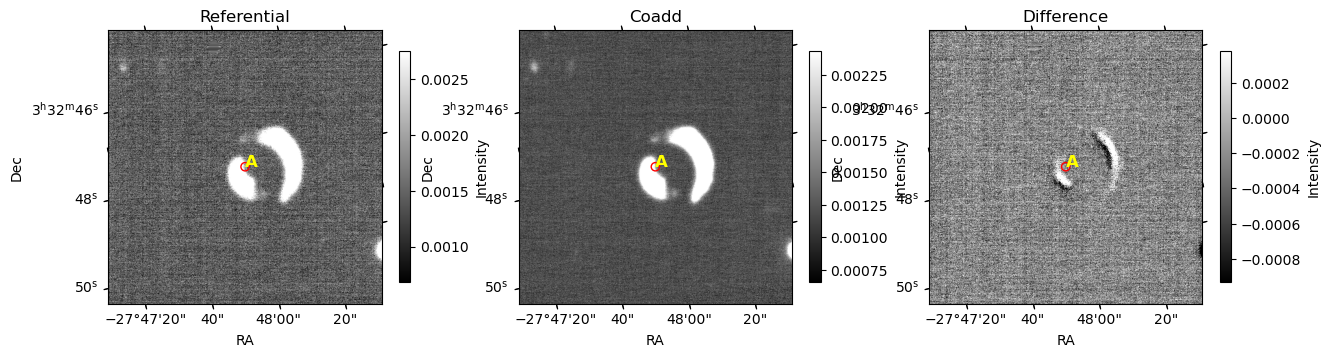

In [19]:
# Repeating the same plot, but now, rescaling the intensity of each image independently to [0,1]

exp_ref_norm, exp_coadd_norm = normalize_exposures(
    injected_exposures[0],
    coadd_exp,
    method="rescale")

vr.injection_steps(
    exp_ref_norm,
    exp_coadd_norm,
    points,
    diference=True,
    cutout_radius_arcsec=10,  # arcsec points
    grid=False, percentiles=[0.1, 99.9], #[5, 95]
    names=['Referential', 'Coadd', 'Difference'])

[INFO] Converted LSST SkyWcs -> Astropy WCS


/home/arestrada88/WORK/Alma_proyect/VeraRubin/plot/injection_plot.py:171: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


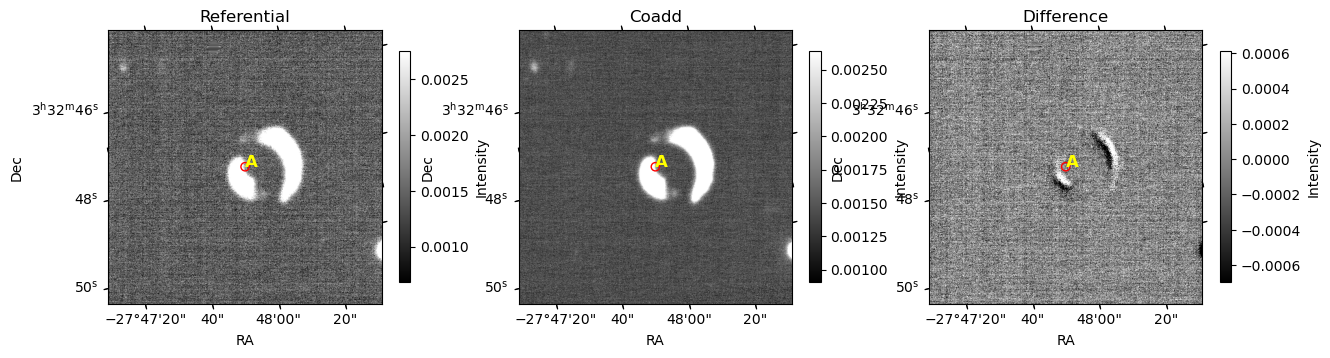

In [20]:
# Repeating the same plot, but now, rescaling both using the global min and max

exp_ref_Gnorm, exp_coadd_Gnorm = normalize_exposures(
    injected_exposures[0],
    coadd_exp,
    method="global_rescale")

vr.injection_steps(
    exp_ref_Gnorm,
    exp_coadd_Gnorm,
    points,
    diference=True,
    cutout_radius_arcsec=10,  # arcsec points
    grid=False, percentiles=[0.1, 99.9], #[5, 95]
    names=['Referential', 'Coadd', 'Difference'])

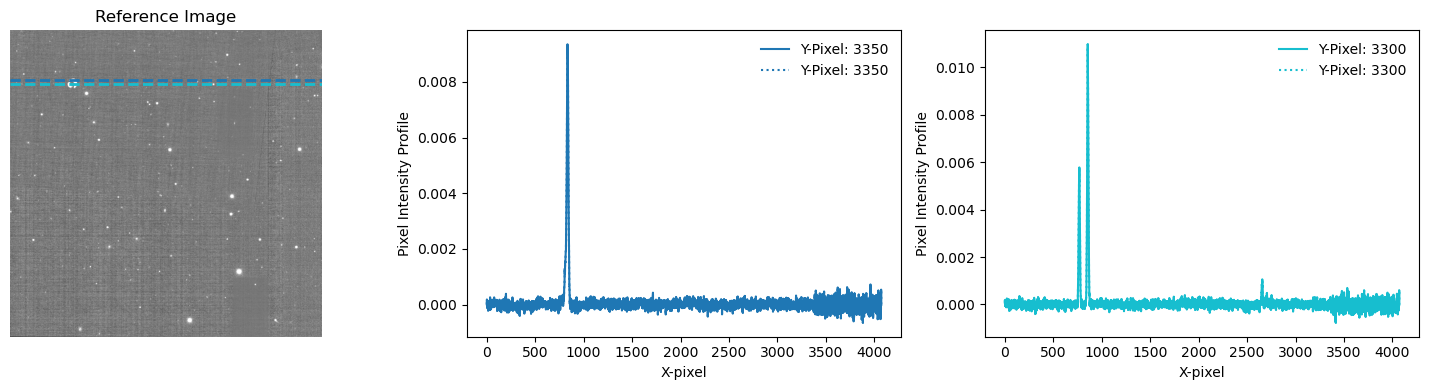

In [21]:
# Pixel plot normalized to the max pixel intensity
y_positions_pixel = [3350, 3300]
image_array_list = [coadd_exp.image.array, coadd_exp.image.array]
vr.pixel_intensity(image_array_list, y_positions_pixel, image_ref=True,
                    save_path=None, colormap='tab10')